<img src="files/Pics/LOGOS.png" width="800">

# Labor 06 - Neurális hálózatok alapjai

## Kézzel írott számjegyek II.

A következő gyakorlat során áttérünk a neurális hálózatok használatára. Pálda feladatnak a kézzel írt számok (0-9) felismerését fogjuk alkalmazni, amit az előző (L05) labor során is. 

### Neurális hálózatok bevezetése

Az eddigi laborok során megismerhettük a tanuló algoritmusok alapjait. A módszerünket bővítettük több változós esetre illetve regressziós és klasszifikációs problémákra is adtunk megoldást. 

Eddigi modellünket üssze foglalhatjuk az alábbi ábra szerint:

<img src="files/Pics/L06_Neuron_01.png" width=450>

,ahol <br>
$x_{n}$-ek jelölik a bemeneteket, $x_{0} = 1$ a BIAS tag <br>
$w_{n}$-ek jelölik a súlyokat <br>
$s$ a szummázott összeget, mely a súlyok és bemenetek szorzatait tartalmazza <br>
$a$ jelöli az aktivációs függvény (szigmoid függvény például) <br>
$y$ jelöli a kimentet <br>

Jobban megnézve ezt az ábrát ténylegesen hasonlít egy biológiai neuronra. 
<img src="files/Pics/L06_Neuron_02.png" width=450>

Vezessük be tehát a fenti modellt, mint neuron vagyis Perceptron modellt.

A neuronok pedig több rétegű hálózatba rendezhetők. Ezt a hálózatot nevezzük neurális hálózatnak vagy MLP-nek (Multi Layer Perceptron).

#### MLP felépítése és működése

Vegyük az alábbi architektúrát:

<img src="files/Pics/L06_NeuralNet.png" width=350>

A vázolt eset egy bemeneti rétegből, egy rejtett rétegből és egy kimeneti rétegből. A bemeneti réteg 2 neuront tartalmaz BIAS nálkül, a rejtett réteg 3 neuront tartalmaz BIAS nélkül és a kimeneti réteg 1 neuronból áll. BIAS tagok a modellben rétegenként adhatók hozzá és egy megfelelő súllyal kapcsolódnak a következő reteg elemihez. 

Teljesen kapcsolt vagy Fully Connected hálóról beszélhetünk, ha minden neuron összeköttetésben áll a következő réteg összes neuronjával. Szigmoid aktivációs függvényt feltételezve, BIAS tagok nélkül tekintsük át a predikció lépéseit (Forward Step) és a szükséges mátrixok és vektorok dimenzióit. A súlyokat ismertnek tekintjük.

$ \underset{1\times 2}{\mathrm{x}} \times \underset{2\times 3}{\mathrm{w^{(1)}}} = \underset{1\times 3}{\mathrm{s^{(2)}}} $

$ \underset{1\times 3}{\mathrm{a^{(2)}}} = f(\underset{1\times 3}{\mathrm{s^{(2)}}}) = sigmoid(\underset{1\times 3}{\mathrm{s^{(2)}}}) $ 

$ \underset{1\times 1}{\mathrm{s^{(3)}}} = \underset{1\times 3}{\mathrm{a^{(2)}}} \times \underset{3\times 1}{\mathrm{w^{(2)}}} $

$ \underset{1\times 1}{\mathrm{\hat{y}}} = f(\underset{1\times 1}{\mathrm{s^{(3)}}}) = sigmoid(\underset{1\times 1}{\mathrm{s^{(3)}}}) $

Példánkon keresztül nézzük meg, hogy működik ez a gyakorlatban.

### 1: Szükséges csomagok beimportálása adatok beolvasása

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
data = loadmat("Lab6data.mat")                          # adatok beolvasása
X = data["X"]
Y = data ["y"]
m = X.shape[0]                                          # adatok elrendezése
del data
print('''Shape of the dataset in order X and Y:
''',X.shape,'\n',Y.shape,'\n')

data = loadmat("Lab6weights.mat")                       # előre optimalizált súlyok beolvasása
w1 = data["Theta1"]
w2 = data["Theta2"]                                     # súlyok elrendezése
del data
print('''Shape of the weights in order 1 and 2:
''',w1.shape,'\n',w2.shape,'\n')


Shape of the dataset in order X and Y:
 (5000, 400) 
 (5000, 1) 

Shape of the weights in order 1 and 2:
 (25, 401) 
 (10, 26) 



A beolvasott adataok dimenzióinak megvizsgálása után láthatjuk, hogy 5000 bemeneti minták van. 400 bemeneti paraméterünk, ami a 20x20 képek pixel számának felel meg. Az első súlymátrixunk 401 oszlopot tartalmaz, ami jelzi, hogy a bementi adatokat a BIAS taggal kiegészítették. A rejtett rétegben 25 neuron van, erre utal az első súlymátrix első dimenziója. A második súlymátrix dimenzióiból látszik, hogy 10 kimeneti neuron szerepel a modellben a 10 számjegynek megfelelően és BIASal kiegészítve 26 bementi értéke van.  

### 2: Adat vizualizáció

Az adatok vizualizációjához véletlen szerűen kiveszünk 100 mintát, vissza alakítjuk eredeti alakjukra és kirajzoltatjuk őket.

Printing some random data ...


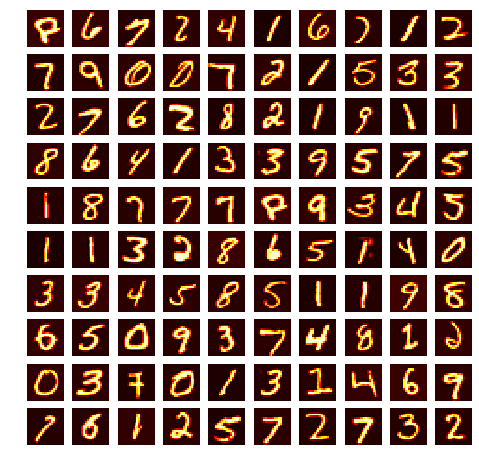

In [3]:
print("Printing some random data ...")
fig, ax = plt.subplots(10,10, figsize =(8,8))               # egy plotra több alplot = subplots (10x10 darab)
for i in range(10):
    for j in range(10):                                     # random adat mind a 100 helyre
        ax[i,j].imshow(X[np.random.randint(0,m+1),:].reshape(20,20, order = "F"), cmap="hot")
        ax[i,j].axis("off")
plt.show()

### 3: Predikció és Pontosság

Az elméleti bevezető alapján implementáljuk a predikciós lépést (Forward Step). Figyeljünk a BIAS tagok hozzá adására és megfelelő mátrix dimenziókra. Mivel klasszifikációs problémáról beszélünk a kiszámított valószínűségek közül itt is ki kell választanunk a megfelelő osztályt.

In [4]:
def sigmoid(z):                                                  # szigmoig függvény definíciója
    return 1/(1+np.exp(-z))

def predict(X,w1,w2):                                            # predikciós függvény definíciója
##########################################################
    m = X.shape[0]

    a1 = np.column_stack((np.ones((m,1)),X))                     # bemeneti réget, BIAS hozzáadása
    s2 = a1 @ w1.T                                               # szummázás
    a2 = np.column_stack((np.ones((m,1)),sigmoid(s2)))           # rejtett réget, BIAS hozzáadása
    s3 = a2 @ w2.T                                               # szummázás
    a3 = sigmoid(s3)                                             # kimeneti réget

    pred = np.argmax(a3,axis=1)+1                                # eredmény (a maximuma az a3-nak)
##########################################################
    return pred                                

Próbáljuk ki a megírt predikciós függvényt. Véletlen szerűen kiválasztunk egy elemet és elvégezzük rajta a predict() függvényt.

Showing You a 7 
The prediction was 7


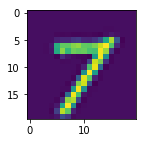

In [33]:
import random
i= random.randint(1,m+1)

X_ex = X[i,:].reshape(1,-1)       # megfelelő mátrix dimenziók és formátum miatt kell a reshape()
pred_ex = predict(X_ex,w1,w2)

print('Showing You a %.0f'% Y[i], '\nThe prediction was %.0f' % pred_ex)
fig = plt.figure(figsize=(2,2))
plt.imshow(X[i,:].reshape(20,20).T)
plt.show()

Elvégezve a predikciót az összes elemre és össze hasonlítva az eredeti címkékkel megkaphatjuk, hogy milyen jól tanulta be a minta adatokat az algoritmus.

In [34]:
def accuracy(pred,Y):                                            # pontosság függvény definíciója
    return (np.sum(pred[:,np.newaxis]==Y)/5000)*100              # predikció vektora megegyezik az Y-al / mintaszám * 100%


pred = predict(X,w1,w2)
print('\nTraining set Accuracy: ', accuracy(pred,Y), ' %')


Training set Accuracy:  97.52  %


<div style="text-align: right">Ez a laborgyakorlat felhasznál elemeket Andrew Ng Machine Learning c. kurzusából.</div>